## A/B Test
https://towardsdatascience.com/when-you-should-prefer-thompson-sampling-over-a-b-tests-5e789b480458

In the <b>A/B testing approach</b>, every alternative (e.g., ad type) is sent to the same number of users.

The <b>problem</b> with A/B tests is that:
* if we allocate too few users, the test is inconclusive;
* if we allocate too many users, we lose opportunities on the less-performing variants.

In [1]:
%reset -f

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import os
import dill
if os.path.isfile("AB_Test.db"): dill.load_session("AB_Test.db")

C:\Users\Victoria\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We need a function to generate a sample of `n` random binary numbers `0/1` with probability `p` for 1 (e.g., an ad click is encoded as 1).

In [110]:
def rand_bin(p,n):
    """Generate random 1/0 sample with given probability.
    Inputs: probability of 1, sample size."""
    rns = np.zeros(n, dtype='int')
    for i in range(n):
        rns[i] = np.random.choice(np.arange(0, 2), p=[1-p, p])
    return rns

Let us consider four types of ads with the following probabilities:

In [111]:
# Probabilities of clicks for the ads
p = [0.09,0.11,0.16,0.18]
ni = len(p)
print("Number of items:", ni)

Number of items: 4


Generating four random samples:

In [112]:
r = [0]*ni # random numbers for each ad: 0 - missing, 1 - click
n = 10000
print("Sample size for each item:", n)
print("Random sample for each item:")
for i in range(len(p)):
    r[i] = rand_bin(p[i],n)
    print(r[i])

Sample size for each item: 10000
Random sample for each item:
[0 0 0 ... 0 0 0]
[1 0 0 ... 1 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 1]


Showing each ad to the same number of 10000 users would produce the following result:

In [113]:
n_AB = n
print(f"Each item was displayed to {n_AB} users in A/B testing.")
clicks_AB = [np.sum(r[i][:n_AB]) for i in range(ni)]
misses_AB = [n_AB - clicks_AB[i] for i in range(ni)]
print(f"A/B\tclicks\tmisses")
for i in range(ni):
    print(f"{i}\t{clicks_AB[i]}\t{misses_AB[i]}")
print(f"Total clicks: {np.sum(clicks_AB)}")

Each item was displayed to 10000 users in A/B testing.
A/B	clicks	misses
0	880	9120
1	1098	8902
2	1605	8395
3	1807	8193
Total clicks: 5390


In [114]:
n_trials_AB = [ni*(t+1) for t in range(len(r[0]))]
n_clicks_AB = [np.sum(r[0][:t]) + np.sum(r[1][:t]) + np.sum(r[2][:t]) + np.sum(r[3][:t]) for t in range(len(r[0]))]                      

In [115]:
# Save number of clicks in AB Test
df_AB = pd.DataFrame(columns=['n_trials_AB','n_clicks_AB'])
df_AB['n_trials_AB'] = n_trials_AB
df_AB['n_clicks_AB'] = n_clicks_AB
df_AB.to_csv('AB_test.clicks_AB.csv',index=False)
df_AB.tail()

,n_trials_AB,n_clicks_AB
9995,39984,5386
9996,39988,5386
9997,39992,5388
9998,39996,5389
9999,40000,5389


Ideally, we would need a smart system that is able to learn dynamically as it gets more data.

This system should:
* explore the different alternatives when the sample size is too small and the results are not reliable;
* exploit the results when they start becoming reliable enough, by sending more and more traffic to the best-performing alternative.

Good news: such a system exists and is called Thompson Sampling.

## Thompson Sampling
Using probability distributions rather than numbers.
The approach we have seen above tried to evaluate each alternative with a single number: its click rate. The problem with this approach is that a single number doesn’t express the uncertainty associated with the estimate itself.

To solve this problem, Thompson Sampling proposes to use a full probability distribution rather than a single number.

The objective of the probability distribution is to express the uncertainty about the estimate of the metric.

Once we have our distributions — one for each alternative — Thompson Sampling works by drawing a random number from each distribution. Then, the alternative associated with the highest number is shown to the user.

What’s the point of doing this? Well, the idea is that if the distributions express a high uncertainty, the outcome depends much on the chance.

In other terms, the less confidence in our belief, the more the system will explore different alternatives. On the contrary, as confidence increases, the system increasingly exploits the best-performing alternative.

In [116]:
def plt_beta(clicks,misses):
    '''Plot beta distribution.
    Inputs: number of clicks, number of misses.'''
    n = clicks + misses     # sample size
    click_rate = clicks / n # probability of click
    
    # get 1000 equally spaced points between 0 and 1 for plotting purposes
    x = np.linspace(start = 0, stop = 1, num = 1_000)
    
    # calculate the probability distribution function of beta
    beta_pdf = stats.beta(a = clicks, b = misses).pdf(x = x)
    
    plt.title("Beta distr., n = "+str(n)+": "+str(clicks)+" clicks, "+str(misses)+" misses")
    plt.xlim(0,1000)
    plt.ylim(0,4)
    plt.plot(beta_pdf, label = 'beta')
    plt.legend()
    plt.show()

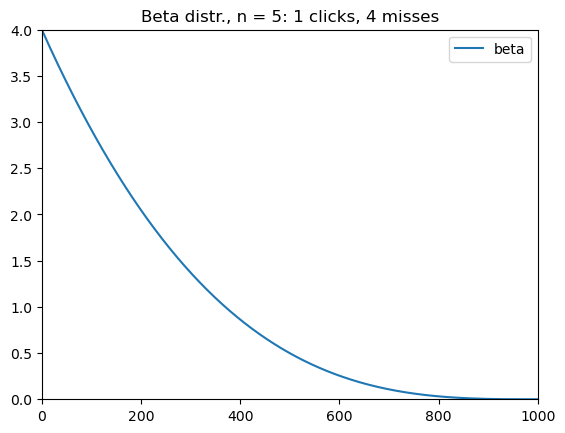

In [117]:
plt_beta(1,4)

Compare beta and normal distributions

In [118]:
def plt_beta_normal(clicks,misses):
    '''Plot beta and normal distributions.
    Inputs: number of clicks, number of misses.'''
    n = clicks + misses     # sample size
    click_rate = clicks / n # probability of click
    
    # get 1000 equally spaced points between 0 and 1 for plotting purposes
    x = np.linspace(start = 0, stop = 1, num = 1_000)
    
    # calculate the probability distribution function of beta
    beta_pdf = stats.beta(a = clicks, b = misses).pdf(x = x)
    # calculate the probability distribution function of normal
    normal_pdf = stats.norm(
      loc = click_rate, 
      scale = np.sqrt(click_rate * (1 - click_rate) / n)
    ).pdf(x = x)
    
    plt.title("n = "+str(n)+": "+str(clicks)+" clicks, "+str(misses)+" misses")
    plt.xlim(0,1000)
    plt.ylim(0,4)
    plt.plot(beta_pdf, label = 'beta')
    plt.plot(normal_pdf,'--', label = 'normal')
    plt.legend()
    plt.show()

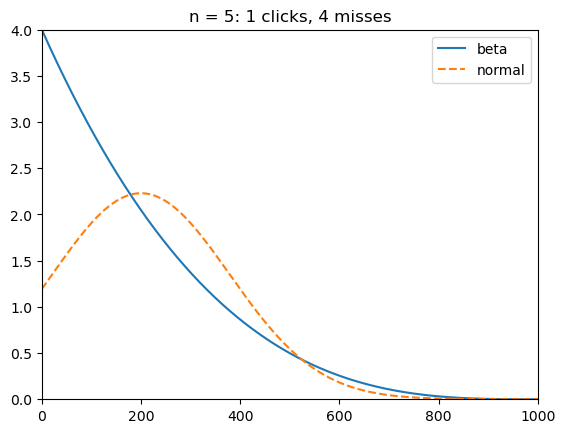

In [119]:
plt_beta_normal(1,4)

The Beta distribution and the Normal distribution become more and more similar as the number of impressions grows. And they become practically the same thing after just 50 iterations.

## Thompson Sampling at work
Let’s make an example to see Thompson Sampling at work.

We want to test 4 versions of an advertisement: grey, red, green, and blue. Suppose that we also know the real click rate for each version.

We will use the Beta distribution. But we need a small adjustment. Since the parameters for Beta (a and b) must be strictly greater than 0, in case at least one between a and b is zero, then we will add 1 to each of them.

In [120]:
def draw_from_beta(clicks, misses):
  """Draw a random number from Beta."""
  
  if min(clicks, misses) == 0:
    clicks += 1
    misses += 1
  
  return np.random.beta(a=clicks, b=misses)

In [121]:
draw_from_beta(1, 4)

0.5823712354559912

In [122]:
draw_from_beta(1, 4)

0.02950856573213958

<b>Algorithm:</b>
For each new user, we must do the following.

1) Based on the current count of clicks and misses for each variant, get the corresponding Beta distribution.

2) Draw a number from each variant’s distribution obtained at step 1.

3) Show the user the variant associated with the highest number.

4) Update the counter with the outcome obtained on the current user (click or miss).

In [123]:
def ThompsonSampling(ni,nt,nd):
    """ThompsonSampling.
    Inputs:
    ni - number of items (variants, e.g. how many different ads are tested);
    nt - number of trials (total number of displays regardless of variant);
    nd - number of initial displays before Thompson Sampling."""
    #print("Number of items:", ni)
    #print("Number of trials:", nt)
    #print("Initial displays:", nd)
   
    # DataFrame of results
    res_df = pd.DataFrame(columns = ['p'+str(i) for i in range(ni)] + ['bi','click','nd'])
    # predicted probabilities of click for each item, the best item type, whether it was clicked, and total number of displays
   
    # Based on the current count of clicks and misses for each variant, get the corresponding Beta distribution.
    clicks_n = np.zeros(ni, dtype='int') # total number of clicks for each item after the current number of trials
   
    displays_n = np.ones(ni, dtype='int')*nd # how many times each item was presented so far, initially 'nd' for each item
    prob_Th = np.zeros(ni, dtype='double') # expected probability of click for each item
    # Initial trials
    for t in range(nd):
        for i in range(ni): # Items (variants)
            clicks_n[i] += r[i][displays_n[i]]
            displays_n[i] += 1 # displayed item 'i' one more time
            prob_Th[i] = clicks_n[i]/displays_n[i]
            res_df.loc[len(res_df)] = np.append(prob_Th.copy(), [i, r[i][displays_n[i]], t*ni+i+1]) # 'click'=1 if clicked, else 0
    # Thompson sampling
    for t in range(nt - nd*ni): # Trials (presentations) remaining
        prob_Th_max = 0
        for i in range(ni): # Items (variants)
            # Draw a number from each item’s distribution.
            prob_Th[i] = draw_from_beta(clicks_n[i], displays_n[i] - clicks_n[i])
            #print("probability of click for ad"+str(i)+":", prob_Th[i])
            if prob_Th[i] > prob_Th_max:
                prob_Th_max = prob_Th[i]
                i_best = i
        res_df.loc[len(res_df)] = np.append(prob_Th.copy(), [i_best, r[i_best][displays_n[i_best]], t+1 + nd*ni])
        displays_n[i_best] += 1
        clicks_n[i_best] += r[i_best][displays_n[i_best]]
    res_df = res_df.astype({'bi':'int32', 'click':'int32', 'nd':'int32'})
    res_df.set_index('nd', inplace=True)
    return res_df

In [127]:
Thompson_df = ThompsonSampling(ni,n,0) # number of trials equals the number of random 0/1 misses/clicks generated above
Thompson_df

,p0,p1,p2,p3,bi,click
nd,,,,,,
1,0.932102,0.461658,0.753311,0.074621,0,0
2,0.871904,0.387588,0.187166,0.788122,0,0
3,0.292901,0.909341,0.420449,0.402989,1,1
4,0.142092,0.195979,0.836164,0.071639,2,0
5,0.079779,0.330648,0.888735,0.956144,3,0
...,...,...,...,...,...,...
9996,0.083285,0.132000,0.148754,0.189025,3,0
9997,0.039167,0.118900,0.148723,0.180808,3,0
9998,0.134131,0.099935,0.157739,0.173685,3,1


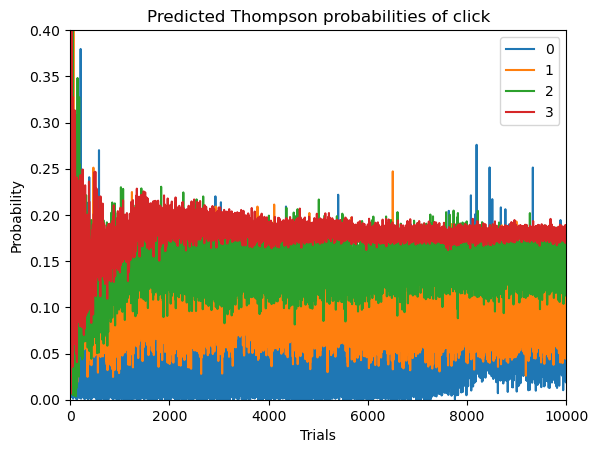

In [128]:
plt.plot(Thompson_df['p0'], label="0")
plt.plot(Thompson_df['p1'], label="1")
plt.plot(Thompson_df['p2'], label="2")
plt.plot(Thompson_df['p3'], label="3")
plt.xlim(0,Thompson_df.shape[0])
plt.ylim(0,0.4)
plt.title('Predicted Thompson probabilities of click')
plt.xlabel('Trials')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [129]:
nt = 100
print(f"Expected click probabilities after {nt} trials and current best choice:")
Thompson_df.loc[nt]

Expected click probabilities after 100 trials and current best choice:


p0       0.073263
p1       0.120267
p2       0.005692
p3       0.175462
bi       3.000000
click    0.000000
Name: 100, dtype: float64

In [130]:
i_best = np.argmax(Thompson_df.loc[nt].iloc[:-2])
i_best_actual = np.argmax(p)
if i_best != np.argmax(p):
    print(f"After {nt} iterations, our belief is still not aligned with the truth:")
    print(f"the expected value of the item {i_best} is greater than the item {i_best_actual}. ")
else:
    print("Coincidentally, our belief is aligned with the truth:")
    print(f"the expected value of the item {i_best_actual} is the highest among all variants. ")

Coincidentally, our belief is aligned with the truth:
the expected value of the item 3 is the highest among all variants. 


But this is just due to chance. As the experience sums up, our estimates will converge to the truth. This means that:

* the mean of the distribution will be closer to the true rate;
* the standard deviation of the distribution will be closer and closer to zero.

In [131]:
print("Check if the expected click probabilities converged to their true values.")
p_pred = Thompson_df.loc[nt].values[:-2]
print("Actual probabilities:", p)
print("Predicted probabilities of clicks:", p_pred)
print("Ratios of predicted to actual probabilities:", p_pred/p)

Check if the expected click probabilities converged to their true values.
Actual probabilities: [0.09, 0.11, 0.16, 0.18]
Predicted probabilities of clicks: [0.07326269 0.1202666  0.00569187 0.17546209]
Ratios of predicted to actual probabilities: [0.8140299  1.09333272 0.03557421 0.97478939]


In [132]:
print(f"The result after {nt} impressions:")
print(f"item\tclicks\tmisses")
displays_n = np.zeros(ni, dtype='int') # Total displays for each variant
clicks_n = np.zeros(ni, dtype='int') # Total clicks for each variant
for i in range(ni):
    Thompson_df_i = Thompson_df[:nt].loc[Thompson_df['bi'] == i]
    displays_n[i] = Thompson_df_i.shape[0]
    clicks_n[i] = np.sum(Thompson_df_i['click'])
    print(f"{i}\t{clicks_n[i]}\t{displays_n[i] - clicks_n[i]}")
print(f"Total clicks across all items: {np.sum(clicks_n)}")

The result after 100 impressions:
item	clicks	misses
0	0	13
1	4	29
2	1	12
3	6	35
Total clicks across all items: 11


In [133]:
# Increase the number of trials!
nt=1000
print(f"The result after {nt} impressions:")
print(f"item\tclicks\tmisses")
displays_n = np.zeros(ni, dtype='int') # Total displays for each variant
clicks_n = np.zeros(ni, dtype='int') # Total clicks for each variant
for i in range(ni):
    Thompson_df_i = Thompson_df[:nt].loc[Thompson_df['bi'] == i]
    displays_n[i] = Thompson_df_i.shape[0]
    clicks_n[i] = np.sum(Thompson_df_i['click'])
    print(f"{i}\t{clicks_n[i]}\t{displays_n[i] - clicks_n[i]}")
print(f"Total clicks across all items: {np.sum(clicks_n)}")

The result after 1000 impressions:
item	clicks	misses
0	1	30
1	10	96
2	27	167
3	114	555
Total clicks across all items: 152


In [134]:
print(f"Clicks for the best item {i_best_actual}: {displays_n[i_best_actual]/nt*100:.2f}%")
print(f"Clicks for the next-best item 2: {displays_n[2]/nt*100:.2f}%")

Clicks for the best item 3: 66.90%
Clicks for the next-best item 2: 19.40%


In [135]:
clicks_n_AB = np.sum([np.sum(r[i][:nt//ni]) for i in range(ni)])
clicks_n_Th = np.sum(clicks_n)
print(f"Thompson Sampling is so effective that, after only {nt} iterations, it has already concentrated {Thompson_df[:nt].loc[Thompson_df['bi']==i_best_actual].shape[0]/nt*100:.2f}% of the displays on the best alternative (item {i_best_actual}) and {Thompson_df[:nt].loc[Thompson_df['bi']==2].shape[0]/nt*100:.2f}% on the second-best (item 2).")
print(f"Using A/B testing we have {clicks_n_AB} clicks, while Thompson Sampling gives us {clicks_n_Th} clicks.")
print(f"This means {(clicks_n_Th/clicks_n_AB - 1)*100:.2f}% more clicks thanks to Thompson Sampling!")

Thompson Sampling is so effective that, after only 1000 iterations, it has already concentrated 66.90% of the displays on the best alternative (item 3) and 19.40% on the second-best (item 2).
Using A/B testing we have 120 clicks, while Thompson Sampling gives us 152 clicks.
This means 26.67% more clicks thanks to Thompson Sampling!


And the difference would become even bigger if we carry out more iterations:

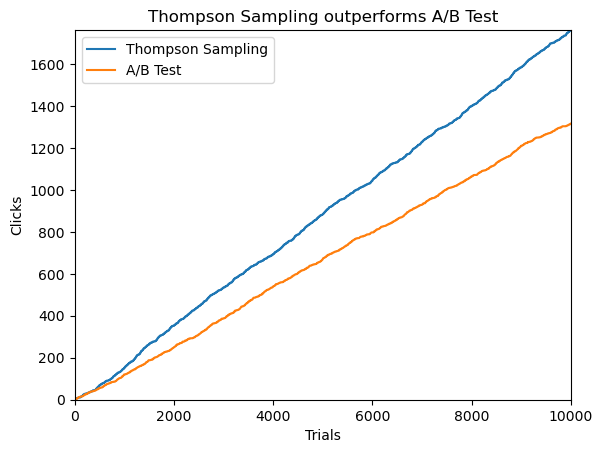

In [136]:
# Cumulative number of clicks
nt_Th = Thompson_df.shape[0] # total number of displays in Thompson sampling
clicks_nt_Th = np.zeros(nt_Th) # How many total clicks across all items for incremental number of trials
nt_i = [0]*ni # number of trials for each item type
n_clicks_Th = 0
for t in range(nt_Th): # all trials (displays)
    item_type = int(Thompson_df.iloc[t]['bi'])
    n_clicks_Th += r[item_type][nt_i[item_type]] # total number of clicks so far
    nt_i[item_type] += 1 # number of displays for item_type
    clicks_nt_Th[t] = n_clicks_Th
n_trials_Th = [i+1 for i in range(nt_Th)]

plt.title("Thompson Sampling outperforms A/B Test")
plt.plot(n_trials_Th,clicks_nt_Th, label="Thompson Sampling")
plt.plot(n_trials_AB,n_clicks_AB, label="A/B Test")
plt.xlabel("Trials")
plt.xlim(0,n)
plt.ylabel("Clicks")
plt.ylim(0,clicks_nt_Th[-1])
plt.legend()
plt.show()

In [137]:
Thompson_df.loc[n].values[:ni]

array([0.09352668, 0.09479921, 0.13313143, 0.17515473])

In [ ]:
try: del clicks_nt_Th_df
except: print("Starting our first Thompson sampling")
nd = 59 # number of displays of each variant before Thompson Sampling
n_sims = 100
fn = 'AB_Test.clicks_Thompson.csv'
try:
    len(clicks_nt_Th_df)
    sim_Th_start = int(clicks_nt_Th_df.columns[-1][3:])+1
except:
    clicks_nt_Th_df = pd.DataFrame()
    #probs = np.zeros((nt,ni), dtype='double')
    probs = []
    sim_Th_start = 0
for sim_Th in range(sim_Th_start, n_sims):
    print("\rSimulation ",sim_Th,end='')
    Thompson_df = ThompsonSampling(ni,n,nd) # Set nd !
    probs.append(Thompson_df.loc[n].values[:ni])
    nt_Th = Thompson_df.shape[0] # total number of displays in Thompson sampling
    # Cumulative number of clicks
    clicks_nt_Th = np.zeros(nt_Th) # How many total clicks across all items for incremental number of trials
    nt_i = [0]*ni # number of trials for each item type
    n_clicks_Th = 0
    for t in range(nt_Th): # all trials (displays)
        item_type = int(Thompson_df.iloc[t]['bi'])
        n_clicks_Th += r[item_type][nt_i[item_type]] # total number of clicks so far
        nt_i[item_type] += 1 # number of displays for item_type
        clicks_nt_Th[t] = n_clicks_Th
    n_trials_Th = [i+1 for i in range(nt_Th)]
    clicks_nt_Th_df['Th_'+str(sim_Th)] = clicks_nt_Th
clicks_nt_Th_df.to_csv(fn,index=False)

clicks_nt_Th_mean = [np.mean(clicks_nt_Th_df.iloc[t]) for t in range(n)] #clicks_nt_Th_df.shape[0]
clicks_nt_Th_sd = [np.std(clicks_nt_Th_df.iloc[t]) for t in range(n)]

plt.title("Thompson Sampling outperforms A/B Test, nd = "+str(nd))
plt.plot(n_trials_Th,[clicks_nt_Th_mean[t] + 3*clicks_nt_Th_sd[t] for t in range(n)], label="mean + 3*SD", c='g')
plt.plot(n_trials_Th,clicks_nt_Th_mean, label="Thompson mean", c='r')
plt.plot(n_trials_Th,[clicks_nt_Th_mean[t] - 3*clicks_nt_Th_sd[t] for t in range(n)], label="mean - 3*SD", c='b')
plt.plot(n_trials_AB,n_clicks_AB, label="A/B Test", c='k')
plt.xlabel("Trials")

plt.xlim(0,n)
plt.ylabel("Clicks")
plt.ylim(0,clicks_nt_Th[-1] + 3*clicks_nt_Th_sd[-1])
plt.legend()
plt.show()

Simulation  34

Green and blue curves show the lower and upper boundaries of the 99.7% confidence interval (+/-3 standard deviations from the mean in red) for the number of clicks in Thompson Sampling.

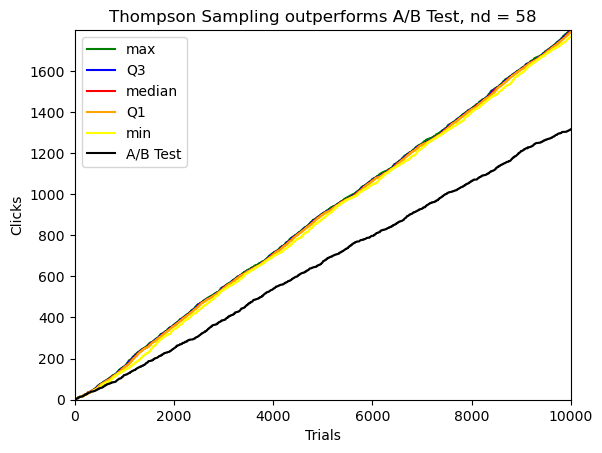

In [47]:
# Quartiles of the number of clicks
clicks_nt_Th_min = np.zeros(n)
clicks_nt_Th_1q = np.zeros(n)
clicks_nt_Th_med = np.zeros(n)
clicks_nt_Th_3q = np.zeros(n)
clicks_nt_Th_max = np.zeros(n)
for t in range(n):
    clicks_nt_Th_min[t], clicks_nt_Th_1q[t], clicks_nt_Th_med[t], clicks_nt_Th_3q[t], clicks_nt_Th_max[t] = np.percentile(clicks_nt_Th_df.iloc[t], q=[0, 25, 50, 75, 100])

plt.title("Thompson Sampling outperforms A/B Test, nd = "+str(nd))
plt.plot(n_trials_Th,clicks_nt_Th_max, label="max", c='g')
plt.plot(n_trials_Th,clicks_nt_Th_3q, label="Q3", c='b')
plt.plot(n_trials_Th,clicks_nt_Th_med, label="median", c='r')
plt.plot(n_trials_Th,clicks_nt_Th_1q, label="Q1", c='orange')
plt.plot(n_trials_Th,clicks_nt_Th_min, label="min", c='yellow')
plt.plot(n_trials_AB,n_clicks_AB, label="A/B Test", c='k')
plt.xlabel("Trials")
plt.xlim(0,n)
plt.ylabel("Clicks")
plt.ylim(0,clicks_nt_Th_max[-1])
plt.legend()
plt.show()

In [48]:
print("Expected probabilities in Thompson Sampling:")
prob_i_mean = []
prob_i_sd = []
prob_i_min = []
prob_i_1q = []
prob_i_med = []
prob_i_3q = []
prob_i_max = []
for i in range(ni):
    probs_i = [probs[sn][i] for sn in range(n_sims)]
    prob_i_mean.append(np.mean(probs_i))
    prob_i_sd.append(np.std(probs_i))
    percentiles = np.percentile(probs_i, q=[0, 25, 50, 75, 100]) # min, Q1, median, Q3, max
    prob_i_min.append(percentiles[0])
    prob_i_1q.append(percentiles[1])
    prob_i_med.append(percentiles[2])
    prob_i_3q.append(percentiles[3])
    prob_i_max.append(percentiles[4])
print("Mean =", prob_i_mean)
print("SD =", prob_i_sd)
print("Min =", prob_i_min)
print("Q1 =", prob_i_1q)
print("Median =", prob_i_med)
print("Q3 =", prob_i_3q)
print("Max =", prob_i_max)

Expected probabilities in Thompson Sampling:
Mean = [0.06263701673544154, 0.040341546604418035, 0.09824652824222323, 0.17997277218308735]
SD = [0.023042322402090115, 0.018139630823482345, 0.034603397793587225, 0.00383270326496974]
Min = [0.019258190632729863, 0.012032575610970394, 0.0173558444138732, 0.16996028401734478]
Q1 = [0.047577235296583816, 0.026941742127620787, 0.0723919317834589, 0.17752516611869643]
Median = [0.06063406116378639, 0.03800011968237682, 0.0988014606464461, 0.1799583324095545]
Q3 = [0.07605960614005991, 0.05202923463413747, 0.12602172649886165, 0.18291156346630166]
Max = [0.12702523897342477, 0.09793241399608893, 0.15693592439944024, 0.18877225205553666]


In [49]:
try:
    len(Th_mean_sd)
except:
    Th_mean_sd = pd.DataFrame(columns=['nd','Th_mean','Th_sd','Th_min','Th_1q','Th_med','Th_3q','Th_max']+['p_mean'+str(i) for i in range(ni)]+['p_sd'+str(i) for i in range(ni)]+['p_min'+str(i) for i in range(ni)]+['p_1q'+str(i) for i in range(ni)]+['p_med'+str(i) for i in range(ni)]+['p_3q'+str(i) for i in range(ni)]+['p_max'+str(i) for i in range(ni)])
res = [nd,clicks_nt_Th_mean[-1], clicks_nt_Th_sd[-1], clicks_nt_Th_min[-1], clicks_nt_Th_1q[-1], clicks_nt_Th_med[-1], clicks_nt_Th_3q[-1], clicks_nt_Th_max[-1]]
for i in range(ni):
    res.append(prob_i_mean[i])
for i in range(ni):
    res.append(prob_i_sd[i])
for i in range(ni):
    res.append(prob_i_min[i])
for i in range(ni):
    res.append(prob_i_1q[i])
for i in range(ni):
    res.append(prob_i_med[i])
for i in range(ni):
    res.append(prob_i_3q[i])
for i in range(ni):
    res.append(prob_i_max[i])
Th_mean_sd.loc[len(Th_mean_sd)] = res

#Th_mean_sd = Th_mean_sd.sort_values('nd').reset_index(drop=True) #sort dataframe: ascending 'nd'
Th_mean_sd.tail(2)

,nd,Th_mean,Th_sd,Th_min,Th_1q,Th_med,Th_3q,Th_max,p_mean0,p_mean1,...,p_med2,p_med3,p_3q0,p_3q1,p_3q2,p_3q3,p_max0,p_max1,p_max2,p_max3
57,57.0,1790.24,7.095238,1756.0,1789.0,1793.0,1795.0,1797.0,0.068615,0.039634,...,0.067212,0.180709,0.080932,0.047376,0.089244,0.183239,0.116544,0.104463,0.164843,0.188864
58,58.0,1790.32,6.663152,1766.0,1788.0,1793.0,1795.0,1798.0,0.062637,0.040342,...,0.098801,0.179958,0.076060,0.052029,0.126022,0.182912,0.127025,0.097932,0.156936,0.188772


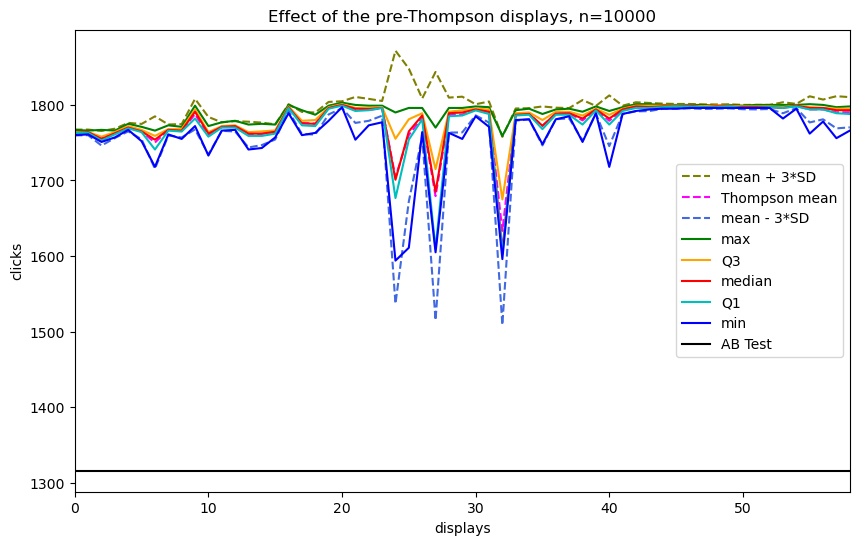

In [50]:
plt.figure(figsize=(10,6))
plt.title("Effect of the pre-Thompson displays, n="+str(n))
plt.xlabel('displays')
plt.xlim(0,Th_mean_sd.shape[0]-1)
plt.ylabel('clicks')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['Th_mean'] + 3*Th_mean_sd['Th_sd'], '--', label="mean + 3*SD", c='olive')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['Th_mean'], '--', label="Thompson mean", c='magenta')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['Th_mean'] - 3*Th_mean_sd['Th_sd'], '--', label="mean - 3*SD", c='royalblue')

plt.plot(Th_mean_sd['nd'], Th_mean_sd['Th_max'], label="max", c='g')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['Th_3q'], label="Q3", c='orange')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['Th_med'], label="median", c='r')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['Th_1q'], label="Q1", c='c')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['Th_min'], label="min", c='b')

plt.plot(Th_mean_sd['nd'], [n_clicks_AB[n//ni]]*len(Th_mean_sd['nd']), label="AB Test", c='k')
plt.legend()
plt.show()

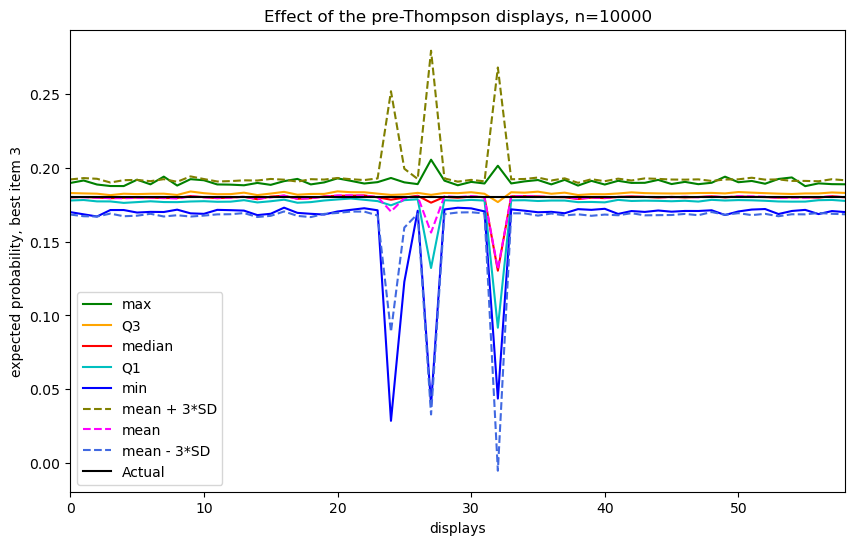

In [51]:
plt.figure(figsize=(10,6))
plt.title("Effect of the pre-Thompson displays, n="+str(n))
plt.xlabel('displays')
plt.xlim(0,Th_mean_sd.shape[0]-1)
plt.ylabel('expected probability, best item 3')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['p_max3'], label="max", c='g')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['p_3q3'], label="Q3", c='orange')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['p_med3'], label="median", c='r')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['p_1q3'], label="Q1", c='c')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['p_min3'], label="min", c='b')

plt.plot(Th_mean_sd['nd'], Th_mean_sd['p_mean3'] + 3*Th_mean_sd['p_sd3'], '--', label="mean + 3*SD", c='olive')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['p_mean3'], '--', label="mean", c='magenta')
plt.plot(Th_mean_sd['nd'], Th_mean_sd['p_mean3'] - 3*Th_mean_sd['p_sd3'], '--', label="mean - 3*SD", c='royalblue')

plt.plot(Th_mean_sd['nd'], [p[i_best_actual]]*(len(Th_mean_sd['nd'])), label="Actual", c='k')
plt.legend()
plt.show()

In [52]:
dill.dump_session("AB_Test.db")

## Conclusion
Thompson Sampling is perfect for online learning because it addresses efficiently the exploration/exploitation dilemma.

It does it by assigning a probability distribution to each variant that should be tested. The distribution serves the purpose of expressing the uncertainty associated with the estimate.

The fact that Thompson Sampling dynamically adapts to the knowledge accumulated from the previous iterations makes it more efficient than A/B testing.

For instance, we have seen an example with 4 variants and — in just 5000 iterations — Thompson Sampling was able to get 25.8% more clicks than A/B testing.

https://towardsdatascience.com/raining-on-your-parade-thompson-sampling-is-not-good-for-a-b-testing-e5a7cbed80fb